In [1]:
# Add root folder to python path
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

# Add some common packages
import numpy as np
import pandas as pd
import math
import scipy.stats as ss
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Set up the failure mode class
from pof.failure_mode import FailureMode
from pof.condition import Condition

fm = FailureMode(alpha=50, beta=1.5, gamma=10)

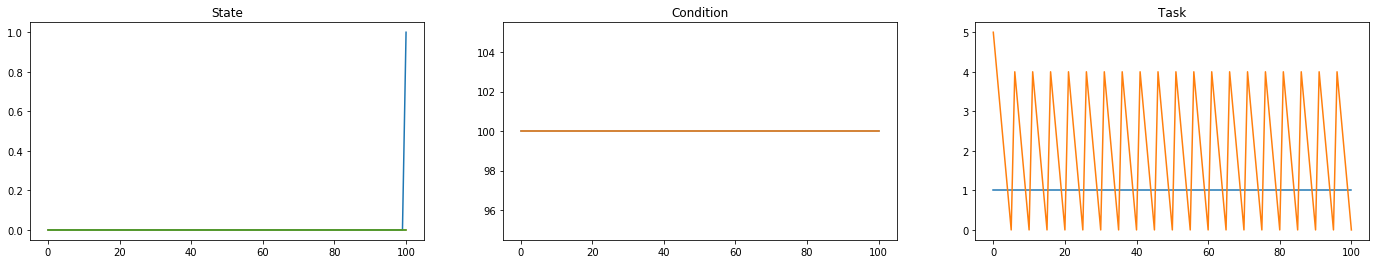

In [3]:
timeline = fm.sim_timeline(150, 100)
fm.plot_timeline()

In [4]:
t_now = 0
t_end = 100

while t_now < t_end:
    print('sim %s' %(t_now))
    timeline = fm.sim_timeline(t_start=t_now, t_end=t_end)
    t_now, tasks = fm.next_tasks(timeline, t_end)

    for task in tasks:

        # Execute the task
        print('execute')
        states = fm.tasks[task].sim_completion(t_end=t_end, events=timeline)

sim 0
execute
sim 5


IndexError: boolean index did not match indexed array along dimension 0; dimension is 96 but corresponding boolean dimension is 101

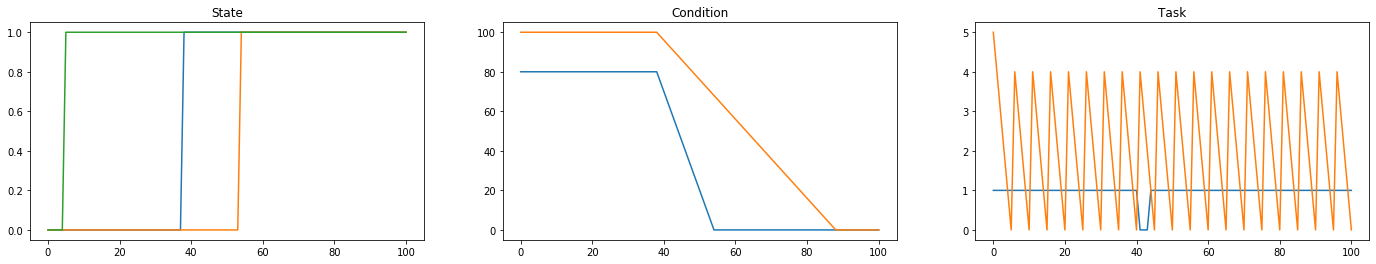

In [5]:
fm.conditions['wall_thickness'].set_condition(80)
fm.conditions['wall_thickness'].set_condition_profile()
fm.sim_timeline(100)
fm.plot_timeline()

In [17]:
timeline

{'time': array([ 950,  951,  952,  953,  954,  955,  956,  957,  958,  959,  960,
         961,  962,  963,  964,  965,  966,  967,  968,  969,  970,  971,
         972,  973,  974,  975,  976,  977,  978,  979,  980,  981,  982,
         983,  984,  985,  986,  987,  988,  989,  990,  991,  992,  993,
         994,  995,  996,  997,  998,  999, 1000]),
 'initiation': array([False, False, False, ...,  True,  True,  True]),
 'wall_thickness': array([80., 80., 80., ...,  0.,  0.,  0.]),
 'external_diameter': array([100., 100., 100., ...,   0.,   0.,   0.]),
 'inspection': array([5., 4., 3., ..., 2., 1., 0.]),
 'detection': array([False, False, False, ...,  True,  True,  True]),
 'failure': array([False, False, False, ...,  True,  True,  True]),
 'ocr': array([ True,  True,  True, ...,  True,  True,  True])}